The main object of this project is to use the current knowledge I have to try and predict a message sender from my friends group chat based on the message he sent.
In this project i will use 2 basic models: TF-IDF to vectorize the messages and KNN to classify them.
The choice of the models are based of the models I learned about (I know that this are not the best models for this task, see "Conclusions")

This project was trained and validated on a private dataset of 20,000 - 30,000 WhatsApp messages.
For privacy reasons, the original dataset is not included in this repository.
However, a synthetic sample dataset (using Gemini) is provided for code verification
and the final performance metrics on the real data are documented in the notebook.
*The results from the synthetic data will probably be better because of Gemini biases that generated the data to make it fit for KNN and tf-idf.

this project will be divided to 2 sections:

section 1: vectorizing the messages - this will include some preprocessing (stop words only, didn't find lemmatization in Hebrew)
and then using tf-idf module to get a vector representation for each message.

section 2: classifying the messages - this will include running GridSearchCV to find optimal hyper-parameter for KNN classification

Conclusions (spoilers ahead):
1. TF-IDF is not ideal for this kind of data (short messages), there are not enough words to create significant differences between messages
2. KNN is not ideal for this kind of data, at least not in the raw form of vectorization using TF-IDF. It creates high dimensionality that challenges KNN to "find"
distances that have meanings
3. Using "sparse-friendly" PCA can decrease the dimensionality problem that challenges KNN and enhance performance
4. Adding meta-data features (sending time and message length) increased the ____
5. Future work could involve using Word Embeddings (like Word2Vec) and lemmatization to see if there are any changes in the results

Section 1: Imports

In [32]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


path = "_chat_family.txt"

Section 2: Preprocessing

Creating a dictionary for stop words:

In [19]:
stop_words = {
    "של", "עם", "על", "אל", "בין", "נגד", "בלי", "תוך", "כדי", "לכן",
    "מאוד", "עוד", "שוב", "שלא", "שכן", "שגם", "אצל", "אליו", "אליה",
    "אליהם", "אליהן", "בכל", "לכל", "מהכל", "ליד",
    "הוא", "היא", "הם", "הן", "אני", "אתה", "את", "אנחנו", "אתם", "אתן",
    "זה", "זו", "זאת", "זהו", "הזה", "הזאת", "האלה", "ההוא", "ההיא",
    "אותו", "אותה", "אותם", "אותן",
    "מהם", "מהן", "בו", "בה", "בהם", "בהן", "עליו", "עליה", "עליהם",
    "עליהן", "שבו", "שבה", "שבהם", "שבהן",
    "גם", "כאשר", "שיהיה", "כאילו", "הרי",
}


Importing the data and making it a df (from txt file)

In [21]:
def split_text(text):
    remove_these_bidi = "\u200e\u200f\u202a\u202b\u202c\u202d\u202e\u2066\u2067\u2068\u2069"
    data = []
    for bidi in remove_these_bidi:
        text = text.replace(bidi, "")
    text = text.replace("\u00a0", " ")
    lines = re.split(r"(?=\[\d{1,2}\.\d{2}\.\d{4},\s\d{1,2}:\d{2}:\d{2}\]\s)", text) #splits messages based on time stamp pattern
    for line in lines:
        if not line.strip():
            continue
        timeStamp, rest = re.split(r"(?<=\]\s)", line, maxsplit=1)
        sender, text = re.split(r"(?<=:)\s+", rest, maxsplit=1)
        data.append([timeStamp, sender, text])
    return data


with open(path, "r", encoding="utf-8") as file:
    text = file.read()
    data = split_text(text)

df = pd.DataFrame(data, columns=["Time_Stamp", "Sender", "Text"])

print(df.head())

               Time_Stamp         Sender  \
0   [5.6.2018, 15:00:03]   Itay Amzaleg:   
1  [1.10.2018, 16:55:27]            אבא:   
2  [1.10.2018, 16:55:27]            אבא:   
3  [1.10.2018, 16:55:27]            אבא:   
4  [1.10.2018, 16:55:28]            אבא:   

                                                Text  
0  השמע הושמט\n[31.1.2014, 10:50:12] האמזלגים: צו...  
1                                    התמונה הושמטה\n  
2                                    התמונה הושמטה\n  
3                                    התמונה הושמטה\n  
4                                    התמונה הושמטה\n  


Cleaning the data

In [41]:
def remove_stop_words(msg, stop_words):
    words = msg.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

def clean_Noise(df, stop_words):
    remove_values = ["", "הודעה זו נמחקה.", ".","סטיקר הושמט","התמונה הושמטה","הודעה נמחקה","השמע הושמט","ההודעה נערכה", "מסמך הושמט" ,"סרטון הווידאו הושמט"]
    clean = df.copy()
    clean["Sender"] = clean["Sender"].str.replace(": ", "", regex=False)
    clean["Sender"] = clean["Sender"].str.replace("Itay Amzaleg", "איתי", regex=False)
    mask = clean["Text"].str.strip().isin(remove_values).fillna(False) | clean["Text"].str.contains(r"(?:https?://|www\.|.pdf)", regex=True, na=False)
    clean = clean[~mask]
    clean["Text"] = clean["Text"].apply(remove_stop_words, args=(stop_words,))
    counts = clean['Sender'].value_counts(normalize=True)
    top_senders = counts[counts >= 0.05].index
    clean = clean[clean['Sender'].isin(top_senders)]
    return clean

df_clean = clean_Noise(df, stop_words)
print(df_clean.head())

                Time_Stamp Sender              Text
7   [1.10.2018, 17:16:24]    אבא:            מתוקים
8   [1.10.2018, 18:15:37]    אבא:           מה המצב
9   [1.10.2018, 18:17:42]    אמא:             סבביש
10  [1.10.2018, 20:36:03]    אבא:          מה קורה?
11  [1.10.2018, 20:36:45]    אמא:  סבבה מכינה א.ערב


Adding meta-data features

In [42]:
def add_time_features(df):
    hours = df['Time_Stamp'].str.extract(r' (\d{1,2}):', expand=False).astype(float)
    df['Time_Of_Day'] = pd.cut(hours,
                                   bins=[0, 6, 12, 18, 24],
                                   labels=[3, 0, 1, 2],
                                   right=False,
                                   include_lowest=True)
    df['Time_Of_Day'] = df['Time_Of_Day'].astype(int)
    return df

def add_length_features(df):
    df['Word_Count'] = df['Text'].str.split().str.len()
    df['Char_Count'] = df['Text'].str.len()
    df['length_ratio'] = np.where(df['Word_Count'] > 0, df['Char_Count'] / df['Word_Count'], 0)
    return df

df_added_features = add_time_features(df_clean)
df_added_features = add_length_features(df_added_features)
print(df_added_features.head())


                Time_Stamp Sender              Text  Time_Of_Day  Word_Count  \
7   [1.10.2018, 17:16:24]    אבא:            מתוקים            1           1   
8   [1.10.2018, 18:15:37]    אבא:           מה המצב            2           2   
9   [1.10.2018, 18:17:42]    אמא:             סבביש            2           1   
10  [1.10.2018, 20:36:03]    אבא:          מה קורה?            2           2   
11  [1.10.2018, 20:36:45]    אמא:  סבבה מכינה א.ערב            2           3   

    Char_Count  length_ratio  
7            6      6.000000  
8            7      3.500000  
9            5      5.000000  
10           8      4.000000  
11          16      5.333333  


Visualisation of the cleaned data so far:

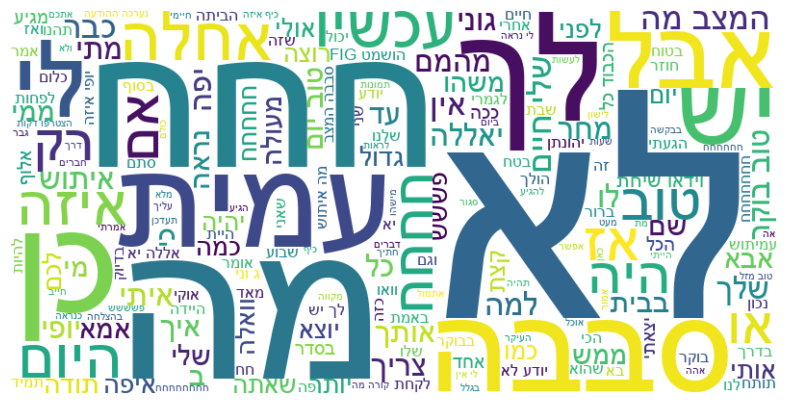

In [43]:
def visualise(df):
    all_text = " ".join(df["Text"].astype(str))
    reversed_words = " ".join([word[::-1] for word in all_text.split()]) #to support Hebrew
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        font_path="C:\\Windows\\Fonts\\arial.ttf"
    ).generate(reversed_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

visualise(df_added_features)

Section 3: Training the model

In [44]:
X = df_added_features[["Text", "Time_Of_Day", "Word_Count", "Char_Count", "length_ratio"]]
y = df_added_features["Sender"]

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split( X, y, test_size=0.2, random_state=18, stratify=y)

preprocessor = ColumnTransformer([
    ("tfidf", TfidfVectorizer(), "Text"),
    ("scaler", StandardScaler(), ["Time_Of_Day", "Word_Count", "Char_Count", "length_ratio"])])

pipe = Pipeline([
        ("prep", preprocessor),
        ("knn", KNeighborsClassifier(metric="cosine", weights="distance"))
    ])

parm_grid = {
    "prep__tfidf__min_df": [1, 2],
    "prep__tfidf__max_df": [0.8, 0.9],
    "prep__tfidf__ngram_range": [(1,1), (1,2)],
    "prep__tfidf__max_features": [None, 3000, 8000],
    "knn__n_neighbors": [1,3,5,7,9,11,13],
}

cv = sk.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
gs = sk.model_selection.GridSearchCV(pipe,parm_grid,cv=cv, scoring="f1_macro")
gs.fit(x_train, y_train)

print("Best params:", gs.best_params_)
print("CV f1_macro:", gs.best_score_)

y_pred = gs.predict(x_test)
print(classification_report(y_test, y_pred,zero_division=0))
cm = confusion_matrix(y_test, y_pred, normalize="true")
np.set_printoptions(precision=2, suppress=True)
print("Confusion matrix (row-normalized):\n", cm)


Best params: {'knn__n_neighbors': 11, 'prep__tfidf__max_df': 0.8, 'prep__tfidf__max_features': 3000, 'prep__tfidf__min_df': 1, 'prep__tfidf__ngram_range': (1, 1)}
CV f1_macro: 0.3781116024182786
              precision    recall  f1-score   support

        אבא:       0.40      0.52      0.45       565
       איתי:       0.33      0.29      0.31       413
        אמא:       0.39      0.41      0.40       495
       עמית:       0.44      0.28      0.35       418

    accuracy                           0.39      1891
   macro avg       0.39      0.38      0.38      1891
weighted avg       0.39      0.39      0.38      1891

Confusion matrix (row-normalized):
 [[0.52 0.15 0.24 0.09]
 [0.33 0.29 0.23 0.15]
 [0.37 0.15 0.41 0.07]
 [0.31 0.2  0.21 0.28]]


The results of this model are nice but not good enough.
accuracy of 0.4 is ~1.5x then random guess which is nice but not really practical

Looking Forward:
1. test other methods for vectorization and classifying to get better results in this task
2. will this method will be enough to distinct only between the gender or age of the sender?
3. try PCA to make the gridsearch faster (and maybe increase accuracy due to dimension reduction)